<a href="https://colab.research.google.com/github/kuzhuppillil/MonReader/blob/main/MonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K


Defining directories containing the testing and training images. There are further 2 subdirectories in both training and testing directories containing flip and notflip images.

In [ ]:
base_dir = '/content/drive/Othercomputers/My Laptop/Apziva Projects/MonReader/images'
train_dir = os.path.join(base_dir,'training')
test_dir = os.path.join(base_dir,'testing')

train_flip_dir = os.path.join(train_dir,'flip')
train_notflip_dir = os.path.join(train_dir,'notflip')

test_flip_dir = os.path.join(test_dir,'flip')
test_notflip_dir = os.path.join(test_dir,'notflip')

File naming conventions are same in both training and testing directories.

In [ ]:
train_flip_fname = os.listdir(train_flip_dir)
train_flip_fname.sort()
print(train_flip_fname[:10])

train_notflip_fname = os.listdir(train_notflip_dir)
train_notflip_fname.sort()
print(train_notflip_fname[:10])

['0001_000000010.jpg', '0001_000000011.jpg', '0001_000000012.jpg', '0001_000000013.jpg', '0001_000000014.jpg', '0001_000000015.jpg', '0001_000000016.jpg', '0001_000000017.jpg', '0001_000000018.jpg', '0001_000000019.jpg']
['0001_000000001.jpg', '0001_000000003.jpg', '0001_000000005.jpg', '0001_000000006.jpg', '0001_000000007.jpg', '0001_000000008.jpg', '0001_000000010.jpg', '0001_000000011.jpg', '0001_000000012.jpg', '0001_000000013.jpg']


Checking the image count in all directories

In [ ]:
print("Total training flip images:",len(os.listdir(train_flip_dir)))
print("Total training notflip images:",len(os.listdir(train_notflip_dir)))
print("Total testing flip images:",len(os.listdir(test_flip_dir)))
print("Total testing notflip images:",len(os.listdir(test_notflip_dir)))

Total training flip images: 1162
Total training notflip images: 1230
Total testing flip images: 290
Total testing notflip images: 307


Displaying sample images from both directories to get a sense of the dataset.

In [ ]:
# output image is configured 4x4
nrows = 2
ncols = 3

pic_index = 0


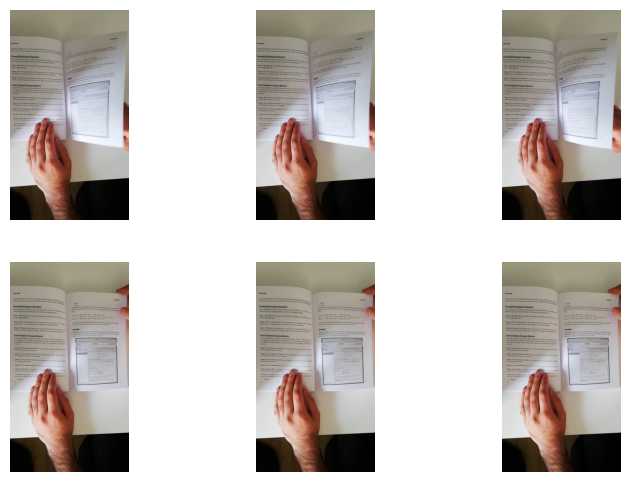

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols*3,nrows*3)

pic_index += 3
next_flip_pic = [os.path.join(train_flip_dir, fname) for fname in train_flip_fname[pic_index-3:pic_index]]
next_notflip_pic = [os.path.join(train_notflip_dir, fname) for fname in train_notflip_fname[pic_index-3:pic_index]]

for i, img_path in enumerate(next_flip_pic+next_notflip_pic):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis("off")

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Building a Convent



*   All pictures are resized to 150x150 color images.
*   We are using a widely used configuration considering the small training samples, stacking 3 layers - convolution + relu + maxpooling. Convolution is using a 3x3 filter and maxpooling using 2x2 filter.
* We are extracting 16 filters for the 1st convolution and then 32 and 64 respectively.






In [ ]:
#input feature map is 150x150x3
img_in = layers.Input(shape=(150,150,3))

#1st convulution using 16 filters of 3x3 followed by max-pooling layer with 2x2 filter
X = layers.Conv2D(16,3, activation='relu')(img_in)
X = layers.MaxPooling2D(2)(X)

#2nd convulution using 32 filters of 3x3 followed by max-pooling layer with 2x2 filter
X = layers.Conv2D(32,3, activation='relu')(X)
X = layers.MaxPool2D(2)(X)

#3rd convulution using 64 filters of 3x3 followed by max-pooling layer with 2x2 filter
X = layers.Conv2D(64,3, activation="relu")(X)
X = layers.MaxPool2D(2)(X)


Adding 2 fully-connected layers at the end of CNN for handling the classification. The output layer will use sigmoid activation to keep the output is a single scalar between 0 and 1.

In [ ]:
#flattening feature map to 1D tensor
X = layers.Flatten()(X)

#Fully connected layer with ReLU activation and 512 hidden unit
X = layers.Dense(512, activation='relu')(X)

#final output layer using sigmoid activation and single layer
output = layers.Dense(1, activation='sigmoid')(X)

#creating a model
model = Model(img_in, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

Configuring the model

In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.001),metrics=[f1_score])

# Data Preprocessing



*   Normalising the pixel range from (0-255) to (0-1), rescaling using data generator rescale parameter.
* We will generate resized images in batches of 20, augmenting the images.



In [ ]:
#all images are rescaled
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode= 'binary'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode= 'binary'
)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


# Training Model

In [ ]:
trained_data = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = test_generator,
    validation_steps = 25,
    verbose =2
)

Epoch 1/30
100/100 - 430s - loss: 0.7002 - f1_score: 0.5464 - val_loss: 0.5427 - val_f1_score: 0.7413 - 430s/epoch - 4s/step
Epoch 2/30
100/100 - 142s - loss: 0.4379 - f1_score: 0.7905 - val_loss: 0.7900 - val_f1_score: 0.3019 - 142s/epoch - 1s/step
Epoch 3/30
100/100 - 118s - loss: 0.2490 - f1_score: 0.8890 - val_loss: 0.2156 - val_f1_score: 0.9108 - 118s/epoch - 1s/step
Epoch 4/30
100/100 - 155s - loss: 0.1588 - f1_score: 0.9382 - val_loss: 0.1231 - val_f1_score: 0.9542 - 155s/epoch - 2s/step
Epoch 5/30
100/100 - 157s - loss: 0.1024 - f1_score: 0.9609 - val_loss: 0.0706 - val_f1_score: 0.9795 - 157s/epoch - 2s/step
Epoch 6/30
100/100 - 143s - loss: 0.0603 - f1_score: 0.9805 - val_loss: 0.0513 - val_f1_score: 0.9839 - 143s/epoch - 1s/step
Epoch 7/30
100/100 - 119s - loss: 0.0491 - f1_score: 0.9790 - val_loss: 0.0514 - val_f1_score: 0.9798 - 119s/epoch - 1s/step
Epoch 8/30
100/100 - 115s - loss: 0.0584 - f1_score: 0.9815 - val_loss: 0.0431 - val_f1_score: 0.9793 - 115s/epoch - 1s/step


# Model Evaluation

Text(0.5, 1.0, 'Training and Validation loss')

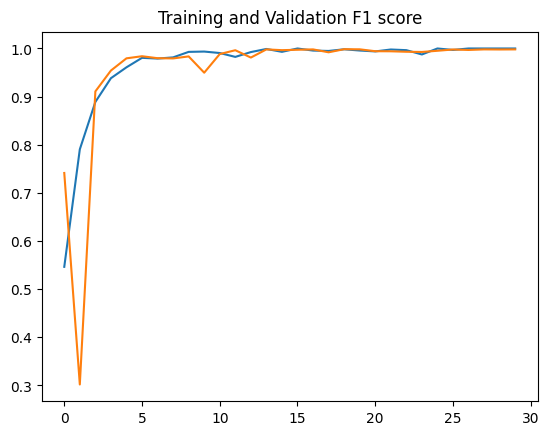

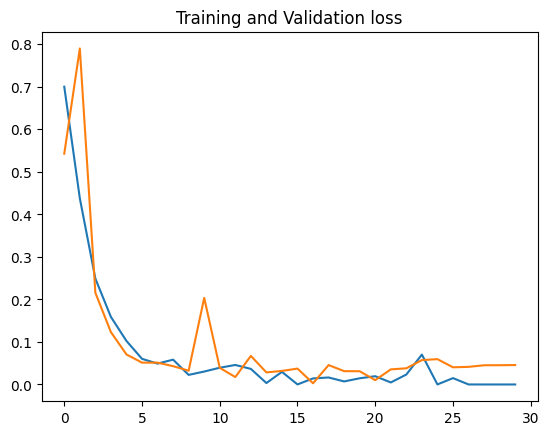

In [ ]:
f1 = trained_data.history["f1_score"]
val_f1 = trained_data.history["val_f1_score"]

loss = trained_data.history["loss"]
val_loss = trained_data.history["val_loss"]

epochs = range(len(f1))

plt.plot(epochs, f1)
plt.plot(epochs, val_f1)
plt.title("Training and Validation F1 score")

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and Validation loss")

